## Analyse des sentiments pour les critiques de films

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve,confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

[nltk_data] Downloading package punkt to /home/anderson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Charger le fichier CSV en un DataFrame pandas
data = pd.read_csv('./data/IMDB_Dataset.csv')
sentiment_mapping = {'positive': 1, 'negative': 0} #transformation des sentiment en binaire
data['sentiment'] = data['sentiment'].map(sentiment_mapping)

## Prétraitement du texte

In [4]:
def preprocess_text(text):
    # Suppression des balises HTML
    text = re.sub(r'<.*?>', '', text)
    
    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    text = ' '.join(filtered_text)
    
    # Suppression de la ponctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Suppression des lettres isolées
    text = re.sub(r'\b\w\b', '', text)
    return text
# Appliquer le prétraitement aux textes
data['review'] = data['review'].apply(preprocess_text)
print(data)

                                                  review  sentiment
0      One reviewers mentioned watching  Oz episode l...          1
1      wonderful little production  filming technique...          1
2      thought wonderful way spend time hot summer we...          1
3      Basically  family little boy  Jake  thinks  zo...          0
4      Petter Mattei   Love Time Money  visually stun...          1
...                                                  ...        ...
49995  thought movie right good job  nt creative orig...          1
49996  Bad plot  bad dialogue  bad acting  idiotic di...          0
49997  Catholic taught parochial elementary schools n...          0
49998   going disagree previous comment side Maltin o...          0
49999  one expects Star Trek movies high art  fans ex...          0

[50000 rows x 2 columns]


## Subdivision des données en ensembles d'entraînement, de validation et de test

In [5]:
X = data['review'].values
y = data['sentiment'].values
# Subdivision des données en ensembles d'entraînement, de validation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train)

['fault actors  put great performances   overall story well executed  movie opens great zinger  crazy old guy forces young Aborigine girl  car road   re forced endure 40 minutes character development entirely new group characters  nt know 40 minutes  turns ones eventually discover girl  body  story progresses thereWhile story pick point  really goes nowhere   hours  asked  point  see characters struggle accusations racism stupidity handled discovery  story ultimately unsatisfying felt unfinished  well acted   strong enough backbone film warrant recommending '
 'first thing thought saw films  really film  least imagine spontaneously hear word  film   entirely symbolic  everything figurative meaning  used express thing symbolic way  find strange  acquainted philosophy  religion  spiritual life  think  fairytale  even weird one  chaotic   legend Zu  perfectly transparent  like  tells us images story fight light darkness  fight old humanity  every one search sens life confronted  film obvi

## Tokenization

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)
vocab_size = len(tokenizer.word_index) + 1

max_len = 100  # Définir la longueur maximale des séquences
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)
X_val_seq = pad_sequences(X_val_seq, maxlen=max_len)

## Création du modèle

In [14]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2023-12-17 14:46:47.387500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-17 14:46:47.387575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anderson-HP-ProBook-4540s): /proc/driver/nvidia/version does not exist
2023-12-17 14:46:48.112122: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 72816640 exceeds 10% of free system memory.
2023-12-17 14:46:49.167662: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 72816640 exceeds 10% of free system memory.
2023-12-17 14:46:49.792752: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 72816640 exceeds 10% of free system memory.


In [15]:
# Entraînement du modèle
history =model.fit(X_train_seq, y_train, batch_size=64, epochs=2, validation_data=(X_val_seq, y_val))

2023-12-17 14:47:27.552648: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12800000 exceeds 10% of free system memory.


Epoch 1/2


2023-12-17 14:47:28.768893: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 72816640 exceeds 10% of free system memory.


500/500 [==============================] - 384s 739ms/step - loss: 2.5857 - accuracy: 0.7262 - val_loss: 0.4714 - val_accuracy: 0.8264
Epoch 2/2
500/500 [==============================] - 316s 633ms/step - loss: 2.5231 - accuracy: 0.7882 - val_loss: 0.4048 - val_accuracy: 0.8516


## Evaluation du modèle

In [16]:
#Evaluation du modèle
# Obtention des prédictions du modèle sur les données de test
y_pred = model.predict(X_test_seq)
y_pred_binary = np.round(y_pred)
# Calcul des métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Affichage des métriques
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

313/313 [==============================] - 21s 64ms/step
Accuracy: 0.8547
Precision: 0.9036470058532192
Recall: 0.7965866243302242
F1 score: 0.8467461238266005


## Test réel avec un avis

In [19]:
with open ('../api/review/tokenizer.pkl','wb') as f:
    pickle.dump(tokenizer,f)

In [22]:
new_review = "good film"
# Prétraitement de la revue (ignoré dans ce cas)
preprocessed_review = new_review
# Encodage de la revue
encoded_review = tokenizer.texts_to_sequences([preprocessed_review])
# Ajustement de la longueur de la séquence
encoded_review = pad_sequences(encoded_review, maxlen=max_len)
# Passage de la revue au modèle
prediction = model.predict(encoded_review)
print(prediction)
# Interprétation de la prédiction
if prediction > 0.5:
    print("La revue est positive.")
else:
    print("La revue est négative.")

1/1 [==============================] - 0s 323ms/step
[[0.5394903]]
La revue est positive.


## Tracé des courbes importantes

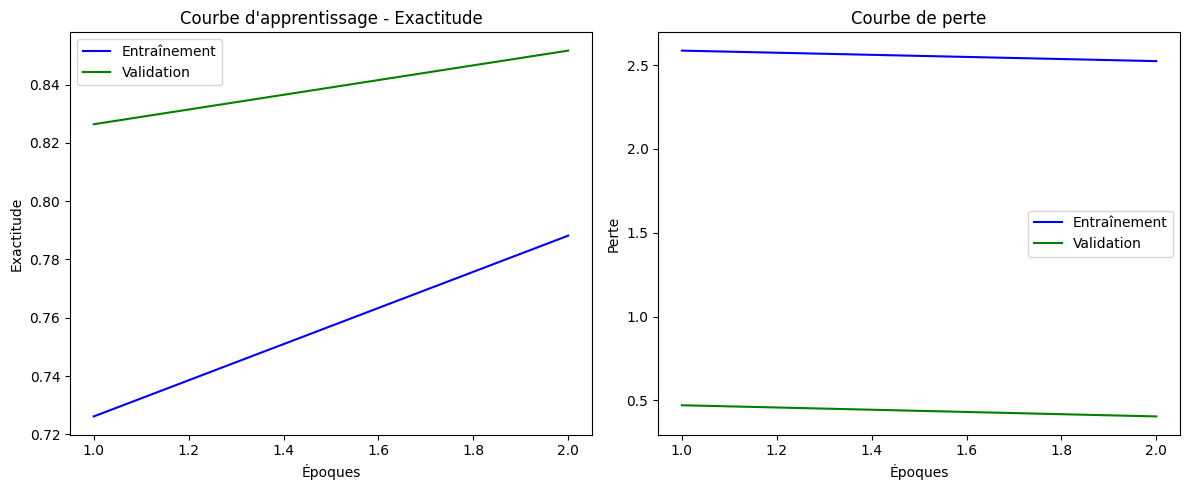

In [19]:
# Extraire les métriques d'apprentissage et de validation à partir de l'historique
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Tracer les courbes d'apprentissage et de perte sur une même figure
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Entraînement')
plt.plot(epochs, val_acc, 'g', label='Validation')
plt.title('Courbe d\'apprentissage - Exactitude')
plt.xlabel('Époques')
plt.ylabel('Exactitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Entraînement')
plt.plot(epochs, val_loss, 'g', label='Validation')
plt.title('Courbe de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Sauvegarde du modèle


INFO:tensorflow:Assets written to: ../api/review/assets


INFO:tensorflow:Assets written to: ../api/review/assets
